###                                      Predict the probability of whether an ad will get clicked or not

In [5]:
### Importing basic libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [56]:
### Importing dataset
df = pd.read_csv('train.csv')

In [62]:
df["click"].value_counts()

0    11700596
1      437214
Name: click, dtype: int64

In [64]:
df.shape

(12137810, 10)

In [65]:
437214/12137810

0.036020830775897794

In [67]:
df.isnull().sum()

ID                   0
datetime             0
siteid         1212515
offerid              0
category             0
merchant             0
countrycode          0
browserid       608327
devid          1820299
click                0
dtype: int64

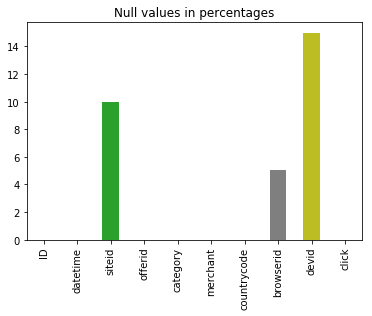

In [13]:
### EDA
#Step 1:- Check for null values
(df.isnull().sum()/len(df) * 100).plot(kind='bar',title="Null values in percentages")

In [76]:
df["devid"].nunique()

3

In [14]:
#Remove null values from dataset
df = df.dropna() 

In [17]:
import datetime
# datetime is in str format. Need to convert to datetime format...
df['datetime'] = pd.to_datetime(train.datetime)

## Deriving separate columns of date, time and day_of_week...
df['date'] = df.datetime.dt.date
df['time'] = df.datetime.dt.time
df['day_of_week'] = df['datetime'].dt.day_name()

## Binning time to DayPart
df['DayPart'] = np.nan
df.loc[(df['time']>=datetime.time(6,0)) & (df['time']<datetime.time(9,0)), 'DayPart'] = 'Early Morning'
df.loc[(df['time']>=datetime.time(9,0)) & (df['time']<datetime.time(13,0)), 'DayPart'] = 'Late Morning'
df.loc[(df['time']>=datetime.time(13,0)) & (df['time']<datetime.time(16,0)), 'DayPart'] = 'Afternoon'
df.loc[(df['time']>=datetime.time(16,0)) & (df['time']<datetime.time(19,0)), 'DayPart'] = 'Evening'
df.loc[(df['time']>=datetime.time(19,0)) & (df['time']<datetime.time(23,0)), 'DayPart'] = 'Night'
df.loc[(df['time']>=datetime.time(23,0)) | (df['time']<datetime.time(6,0)), 'DayPart'] = 'Late Night'

In [19]:
## Cleaning browserid (merging synonymous variables)
df.loc[(df['browserid']=='InternetExplorer') | (df['browserid']=='IE') | (df['browserid']=='Internet Explorer'), 'browserid'] = 'IE'
df.loc[(df['browserid']=='Firefox') | (df['browserid']=='Mozilla') | (df['browserid']=='Mozilla Firefox'), 'browserid'] = 'Mozilla'
df.loc[(df['browserid']=='Chrome') | (df['browserid']=='Google Chrome'), 'browserid'] = 'Chrome'

In [20]:
## Removing redundant columns after wrangling done above
df.drop(['ID', 'datetime', 'time', 'date'],1, inplace=True)

### Create a backup copy
df_copy_1 = df.copy()

Text(0,0.5,'Number of clicks')

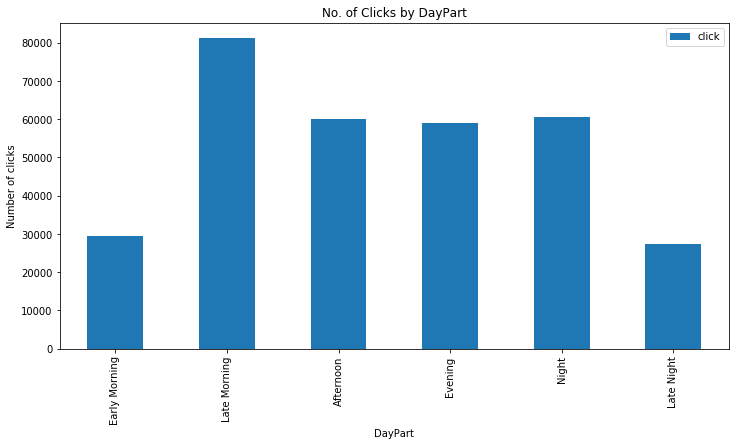

In [22]:
### Plotting graphs to understand variable relationships
## Clicks by DayPart
daypart_order = ['Early Morning','Late Morning','Afternoon','Evening','Night','Late Night']
df.groupby('DayPart').agg({'click':'sum'}).loc[daypart_order].plot(kind='bar',figsize=(12,6), title='No. of Clicks by DayPart')
plt.ylabel('Number of clicks')

Text(0,0.5,'Number of clicks')

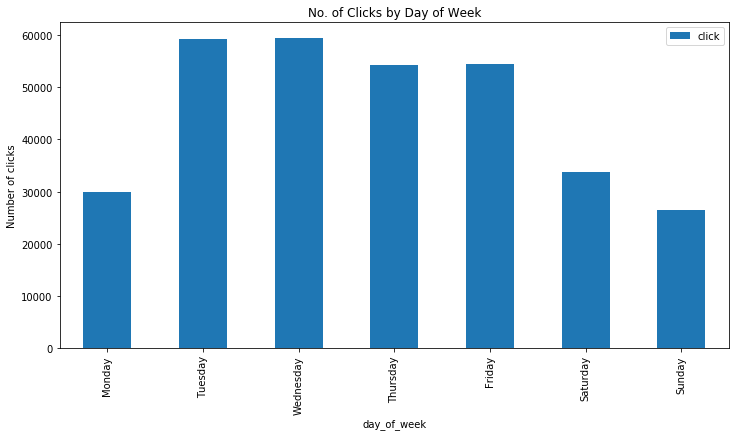

In [23]:
## Clicks by Day of Week
dayofweek_order = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
df.groupby('day_of_week').agg({'click':'sum'}).loc[dayofweek_order].plot(kind='bar',figsize=(12,6), title='No. of Clicks by Day of Week')
plt.ylabel('Number of clicks')

Text(0,0.5,'Number of clicks')

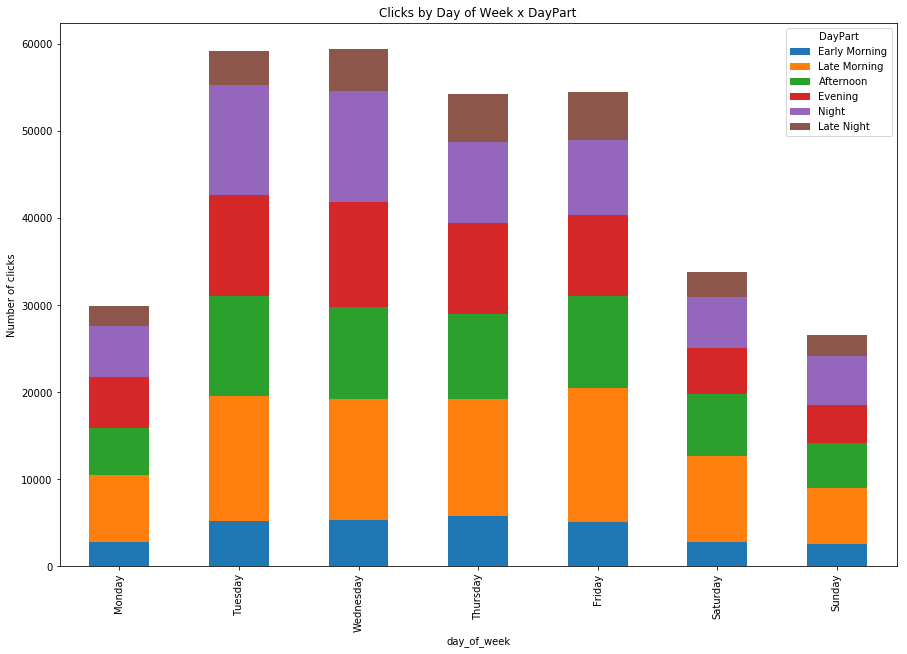

In [24]:
## Clicks by Day of Week x DayPart
res =  df[df['click']==1].groupby(['day_of_week','DayPart']).size().unstack()
res = res[['Early Morning','Late Morning','Afternoon','Evening','Night','Late Night']]
res.loc[dayofweek_order].plot(kind='bar',stacked=True,figsize=(15,10), title='Clicks by Day of Week x DayPart')
plt.ylabel('Number of clicks')

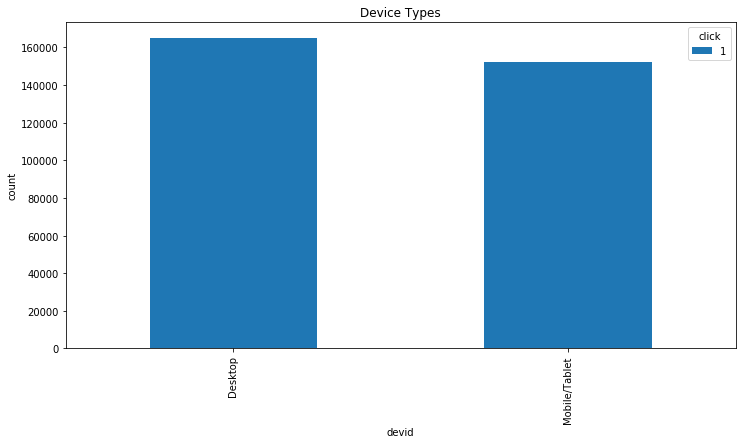

In [26]:
## Clicks by Device
df[df['click']==1].groupby(['devid', 'click']).size().unstack().plot(kind='bar', title="Device Types", figsize=(12,6))
plt.ylabel('count')
len(df[(df['devid']=='Tablet') & (df['click']==1)])/len(df[df['click']==1])
# The graph output suggests tablet to be merged with mobile
df.loc[(df['devid']=='Mobile') | (df['devid']=='Tablet'), 'devid'] = 'Mobile/Tablet'

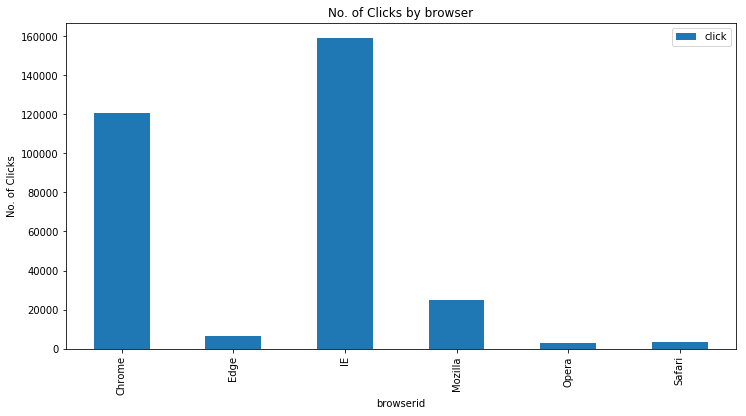

In [28]:
## Clicks by Browser
df.groupby('browserid').agg({'click':'sum'}).plot(kind='bar', figsize=(12,6), title='No. of Clicks by browser')
plt.ylabel('No. of Clicks')
# The graph output suggests Edge, Mozilla, Opera, Safari to be merged
df.loc[(df['browserid']=='Edge') | (df['browserid']=='Mozilla') | (df['browserid']=='Opera') | (df['browserid']=='Safari'), 'devid'] = 'Other Browsers'

In [31]:
### Addressing Class Imbalance
df_click_yes = df[df['click']==1]
df_click_no = df[df['click']==0]
df_click_no_sample = df_click_no.sample(n=500000)
df_balanced = pd.concat([df_click_yes, df_click_no_sample], axis=0)

In [32]:
### Label encoding the features
## Separating features and target
X = df_balanced.drop(['click'],1)
y = df_balanced['click']
## Label Encoding features
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
for x in list(X):
    X[x] = le.fit_transform(X[x])

In [33]:
### Target mean encoding
df_mean_encoding = pd.concat([X,y],1)
for x in list(df_mean_encoding.drop(['click'],1)):
    df_mean_encoding[x] = df_mean_encoding[x].map(df_mean_encoding.groupby(x)['click'].mean())

In [38]:
### Feature Selection/Reduction
## Separating features and target
X = df_mean_encoding.drop(['click'],1)
y = df_mean_encoding['click']
## Creating train test splits
from sklearn.model_selection import train_test_split as tts
X_train, X_test, y_train, y_test = tts(X,y, test_size=0.3, random_state=42)
## Chi-Square for feature selection
from sklearn.feature_selection import chi2, f_classif, SelectKBest
selector = SelectKBest(score_func=chi2, k=5)
selector.fit(X_train, y_train)
cols = selector.get_support(indices=True)
print(X_train.columns[cols])

Index(['siteid', 'offerid', 'countrycode', 'browserid', 'devid'], dtype='object')


In [39]:
X_train_k_best = X_train.iloc[:,cols]
X_test_k_best = X_test.iloc[:,cols]

In [40]:
### Model building/performance
## Logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import r2_score, confusion_matrix, accuracy_score, roc_auc_score, classification_report
log_reg = LogisticRegression()
log_reg.fit(X_train_k_best, y_train)
accuracy_score(y_test, log_reg.predict(X_test_k_best))

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.9792375127420999

In [41]:
confusion_matrix(y_test, log_reg.predict(X_test_k_best))

array([[147595,   2374],
       [  2718,  92563]])

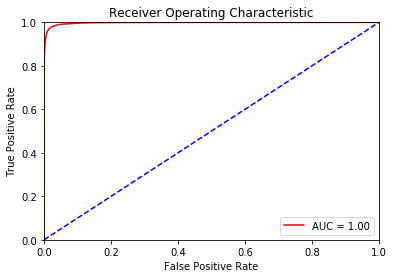

In [52]:
import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification
probs = log_reg.predict_proba(X_test_k_best)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'r', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'b--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [43]:
print(classification_report(y_test, log_reg.predict(X_test_k_best)))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98    149969
           1       0.97      0.97      0.97     95281

   micro avg       0.98      0.98      0.98    245250
   macro avg       0.98      0.98      0.98    245250
weighted avg       0.98      0.98      0.98    245250



In [77]:
## RandomForest Classifier
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=400, n_jobs=-1, min_samples_split=0.12, random_state=42)
rfc.fit(X_train_k_best, y_train)
accuracy_score(y_test, rfc.predict(X_test_k_best))

0.9788053007135576

In [78]:
print(classification_report(y_test, rfc.predict(X_test_k_best)))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98    149969
           1       0.97      0.97      0.97     95281

   micro avg       0.98      0.98      0.98    245250
   macro avg       0.98      0.98      0.98    245250
weighted avg       0.98      0.98      0.98    245250



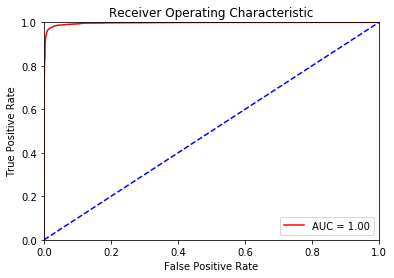

In [51]:
import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification
probs = rfc.predict_proba(X_test_k_best)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'r', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'b--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()